In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import enum

ranks = {
    "two" : 2,
    "three" : 3,
    "four" : 4,
    "five" : 5,
    "six" : 6,
    "seven" : 7,
    "eight" : 8,
    "nine" : 9,
    "ten" : 10,
    "jack" : 10,
    "queen" : 10,
    "king" : 10,
    "ace" : (1, 11)
}

class Suit(enum.Enum):
    spades = "spades"
    clubs = "clubs"
    diamonds = "diamonds"
    hearts = "hearts"


class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value

    def __str__(self):
        return self.rank + " of " + self.suit.value

class Deck:
    def __init__(self, num=1):
        self.cards = []
        for i in range(num):
            for suit in Suit:
                for rank, value in ranks.items():
                    self.cards.append(Card(suit, rank, value))

    def shuffle(self):
        random.shuffle(self.cards)

    def deal(self):
        return self.cards.pop(0)

    def peek(self):
        if len(self.cards) > 0:
            return self.cards[0]

    def add_to_bottom(self, card):
        self.cards.append(card)

    def __str__(self):
        result = ""
        for card in self.cards:
            result += str(card) + "\n"
        return result

    def __len__(self):
        return len(self.cards)

In [25]:
# This follows the same, official rules every time.
# Still need to figure out what happens if there are multiple Aces.
def dealer_eval(player_hand):
    num_ace = 0
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # use 1 for Ace
        else:
            use_one += card.value

    if num_ace > 0:
        # See if using 11 instead of 1 for the Aces gets the
        # dealer's hand value closer to the [17, 21] range

        # The dealer will follow Hard 17 rules.
        # This means the dealer will not hit again if
        # the Ace yields a 17.

        # This also means that Aces initially declared as 11's can
        # be changed to 1's as new cards come.

        ace_counter = 0
        while ace_counter < num_ace:
            # Only add by 10 b/c 1 is already added before
            use_eleven = use_one + 10

            if use_eleven > 21:
                return use_one
            elif use_eleven >= 17 and use_eleven <= 21:
                return use_eleven
            else:
                # The case where even using Ace as eleven is less than 17.
                use_one = use_eleven

            ace_counter += 1

        return use_one
    else:
        return use_one

In [26]:
def player_eval(player_hand):
    num_ace = 0
    # use_one means that every ace that in the hand is counted as one.
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # use 1 for Ace
        else:
            use_one += card.value

    if num_ace > 0:
        # Define player policy for Aces:
        # Make Aces 11 if they get you to the range [18,21]
        # Otherwise, use one.

        ace_counter = 0
        while ace_counter < num_ace:
            # Only add by 10 b/c 1 is already added before
            use_eleven = use_one + 10

            if use_eleven > 21:
                return use_one
            elif use_eleven >= 18 and use_eleven <= 21:
                return use_eleven
            else:
                # This allows for some Aces to be 11s, and others to be 1.
                use_one = use_eleven

            ace_counter += 1

        return use_one
    else:
        return use_one

In [27]:
def dealer_turn(dealer_hand, deck):
    # Calculate dealer hand's value.
    dealer_value = dealer_eval(dealer_hand)

    # Define dealer policy (is fixed to official rules)

    # The dealer keeps hitting until their total is 17 or more
    while dealer_value < 17:
        # hit
        dealer_hand.append(deck.deal())
        dealer_value = dealer_eval(dealer_hand)

    return dealer_value, dealer_hand, deck

In [28]:
import random
import numpy as np
import gym
from gym import error, spaces, utils
from gym.utils import seeding

INITIAL_BALANCE = 1000
NUM_DECKS = 2

class BlackjackEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(BlackjackEnv, self).__init__()

        # Initialize the blackjack deck.
        self.bj_deck = Deck(NUM_DECKS)

        self.player_hand = []
        self.dealer_hand = []

        self.count = 0
        self.real_count = 0

        self.reward_options = {"lose":-100, "tie":0, "win":100}

        # hit = 0, stand = 1
        self.action_space = spaces.Discrete(2)

        self.cards_to_add = []

        '''
        First element of tuple is the range of possible hand values for the player. (3 through 20)
        This is the possible range of values that the player will actually have to make a decision for.
        Any player hand value 21 or above already has automatic valuations, and needs no input from an
        AI Agent.

        However, we also need to add all the hand values that the agent could possibly end up in when
        they bust. Maybe the agent can glean some correlations based on what hand value they bust at,
        so this should be in the observation space. Also, the layout of OpenAI Gym environment class
        makes us have to include the bust-value in the step() function because we need to return that
        done is true alongside the final obs, which is the bust-value.
        '''

        # Second element of the tuple is the range of possible values for the dealer's upcard. (2 through 11)
        self.observation_space = spaces.Tuple((spaces.Discrete(20), spaces.Discrete(10), spaces.Discrete(13)))

        self.done = False

    def _take_action(self, action):
        if action == 0: # hit
            self.player_hand.append(self.bj_deck.deal())

        # re-calculate the value of the player's hand after any changes to the hand.
        self.player_value = player_eval(self.player_hand)

    def step(self, action):
        self._take_action(action)

        # End the episode/game is the player stands or has a hand value >= 21.
        self.done = action == 1 or self.player_value >= 21

        # rewards are 0 when the player hits and is still below 21, and they
        # keep playing.
        rewards = 0

        if self.done:
            # CALCULATE REWARDS
            if self.player_value > 21: # above 21, player loses automatically.
                rewards = self.reward_options["lose"]
            elif self.player_value == 21: # blackjack! Player wins automatically.
                rewards = self.reward_options["win"]
            else:
                ## Begin dealer turn phase.

                dealer_value, self.dealer_hand, self.bj_deck = dealer_turn(self.dealer_hand, self.bj_deck)

                ## End of dealer turn phase

                #------------------------------------------------------------#

                ## Final Compare

                if dealer_value > 21: # dealer above 21, player wins automatically
                    rewards = self.reward_options["win"]
                elif dealer_value == 21: # dealer has blackjack, player loses automatically
                    rewards = self.reward_options["lose"]
                else: # dealer and player have values less than 21.
                    if self.player_value > dealer_value: # player closer to 21, player wins.
                        rewards = self.reward_options["win"]
                    elif self.player_value < dealer_value: # dealer closer to 21, dealer wins.
                        rewards = self.reward_options["lose"]
                    else:
                        rewards = self.reward_options["tie"]

        self.balance += rewards

        for card in self.player_hand:
            if card.rank == "ace":
        # Special handling for aces
                self.count = self.count - 1
            elif card.value > 9:
                self.count = self.count - 1
            elif card.value < 7:
                self.count = self.count + 1

        for card in self.dealer_hand:
            if card.rank == "ace":
                # Special handling for aces
                self.count = self.count - 1
            elif card.value > 9:
                self.count = self.count - 1
            elif card.value < 7:
                self.count = self.count + 1

        if(self.count < -5):
            self.real_count = -6
        elif(self.count > 5):
            self.real_count = 6
        else:
            self.real_count = self.count



        # Subtract by 1 to fit into the possible observation range.
        # This makes the possible range of 3 through 22 into 1 through 20



        count_value_obs = self.real_count + 7

        player_value_obs = self.player_value - 2

        if self.player_value > 21:
          player_value_obs = 20



        # get the value of the dealer's upcard, this value is what the agent sees.
        # Subtract by 1 to fit the possible observation range of 1 to 10.
        upcard_value_obs = dealer_eval([self.dealer_upcard]) - 1

        # the state is represented as a player hand-value + dealer upcard pair + what the current count is.
        obs = np.array([player_value_obs, upcard_value_obs, count_value_obs])

        return obs, rewards, self.done, {}

    def reset(self): # resets game to an initial state
        # Add the player and dealer cards back into the deck.

        self.cards_to_add += self.player_hand + self.dealer_hand
        #self.bj_deck.cards += self.player_hand + self.dealer_hand #FIGURE OUT WHAT THIS IS.



        # Shuffle before beginning. Only shuffle once before the start of each game. DON"T DO THIS.
        #self.bj_deck.shuffle()

        self.balance = INITIAL_BALANCE

        self.done = False


        # returns the start state for the agent
        # deal 2 cards to the agent and the dealer
        self.player_hand = [self.bj_deck.deal(), self.bj_deck.deal()]
        self.dealer_hand = [self.bj_deck.deal(), self.bj_deck.deal()]
        self.dealer_upcard = self.dealer_hand[0]

        # calculate the value of the agent's hand
        self.player_value = player_eval(self.player_hand)

        if self.player_value > 21:
          player_value_obs = 21 - 2

        #Our count is reinitialized to start at 0.

        count_value_obs = self.real_count + 7

        #count_value_obs = self.count + 7 DO I NEED TO DO THIS

        # Subtract by 1 to fit into the possible observation range.
        # This makes the possible range of 2 through 20 into 1 through 18
        player_value_obs = self.player_value - 2

        if self.player_value > 21:
          player_value_obs = 21 - 2

        # get the value of the dealer's upcard, this value is what the agent sees.
        # Subtract by 1 to fit the possible observation range of 1 to 10.
        upcard_value_obs = dealer_eval([self.dealer_upcard]) - 1

        # the state is represented as a player hand-value + dealer upcard pair.
        obs = np.array([player_value_obs, upcard_value_obs, count_value_obs])

        return obs

    def render(self, mode='human', close=False):
        # convert the player hand into a format that is
        # easy to read and understand.
        hand_list = []
        for card in self.player_hand:
            hand_list.append(card.rank)

        # re-calculate the value of the dealer upcard.
        upcard_value = dealer_eval([self.dealer_upcard])

        print(f'Balance: {self.balance}')
        print(f'Player Hand: {hand_list}')
        print(f'Player Value: {self.player_value}')
        print(f'Dealer Upcard: {upcard_value}')
        print(f'Done: {self.done}')

        print()

In [29]:
env1 = BlackjackEnv()

env1.reset()

env1.bj_deck.shuffle()


total_rewards = 0
NUM_EPISODES = 1000

for i in range(NUM_EPISODES):
    env1.reset()

    while env1.done == False:
        action = env1.action_space.sample()

        new_state, reward, done, desc = env1.step(action)
        total_rewards += reward
        print(len(env1.dealer_hand))


    if (i % 8 == 0):
        env1.bj_deck.shuffle()
        env1.count = 0
        env1.real_count = 0
        env1.bj_deck.cards += env1.cards_to_add

avg_reward = total_rewards / NUM_EPISODES
print(avg_reward)




# env1.player_hand = [env1.bj_deck.deal(), env1.bj_deck.deal()]




# for card in env1.player_hand:
#     print(card.value)
#     if((card.value > 9) or (card.rank == "ace")):
#         env1.count = env1.count - 1
#     elif((card.value < 7)):
#         env1.count = env1.count + 1
# for card in env1.dealer_hand:
#     if(card.value > 9 or card.rank == "ace"):
#         env1.count = env1.count - 1
#     elif(card.value < 7):
#         env1.count = env1.count + 1

# env1.reset()
# env1.count = 0
# env1.bj_deck.cards += env.cards_to_add





2
2
2
2
2
2
2
2
4
2
2
2
2
2
2
4
2
2
4
2
2
2
3
5
3
2
2
2
2
4
2
3
2
3
2
2
2
2
2
2
2
2
3
2
2
3
3
3
2
2
4
2
4
2
3
2
2
2
2
2
4
2
2
2
2
2
4
2
2
2
4
2
3
4
3
2
2
3
3
2
2
3
2
2
4
2
2
2
2
2
3
3
2
2
2
2
2
3
2
4
3
3
2
4
2
2
4
2
2
2
3
2
5
2
3
2
2
2
3
2
2
2
2
3
2
2
3
2
4
3
3
2
4
3
2
2
2
2
2
2
2
4
2
2
3
2
2
3
2
2
3
2
5
2
2
4
2
2
5
3
2
2
2
2
2
3
2
2
3
4
2
2
3
5
2
3
2
2
2
2
2
2
2
2
2
4
4
3
2
2
2
2
2
3
2
2
3
3
5
4
2
4
3
2
2
3
2
3
3
2
2
2
2
4
2
2
3
2
5
2
4
4
2
4
2
2
2
2
2
3
2
4
2
4
2
2
2
2
4
2
3
2
5
2
2
2
2
2
2
2
2
2
4
2
2
2
3
2
4
2
2
2
2
3
2
2
2
4
2
2
4
3
3
3
2
2
4
2
2
2
2
2
2
2
3
2
3
2
2
2
3
2
2
2
2
2
2
2
2
3
2
2
5
2
2
2
2
4
2
2
2
2
2
2
2
2
2
2
3
3
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
4
2
2
2
2
2
2
2
2
5
2
4
2
3
2
2
2
3
2
2
2
2
2
3
2
3
3
2
2
2
3
4
4
2
2
6
2
2
2
2
2
2
3
3
3
3
3
2
4
2
2
2
5
2
2
5
4
3
3
2
4
3
4
2
2
3
2
2
4
2
2
3
2
4
4
4
3
2
2
4
2
4
2
2
2
2
4
3
2
2
2
3
2
2
3
2
2
2
5
2
2
4
4
4
2
3
2
3
2
2
4
3
2
3
2
2
2
2
2
2
2
2
2
3
2
2
3
2
2
2
2
2
2
3
3
2
2
2
3
2
2
4
2
3
2
2
3
2
4
2
4
2
2
2
3
2
2
2


In [30]:
env1.observation_space[2].n



13

In [31]:
import random
env = BlackjackEnv()

total_rewards = 0
NUM_EPISODES = 1000

for i in range(NUM_EPISODES):
    env.reset()

    while env.done == False:
        action = env.action_space.sample()

        new_state, reward, done, desc = env.step(action)
        total_rewards += reward


    if (i % 10 == 0):
        env.bj_deck.shuffle()
        env.count = 0
        env.real_count = 0
        env.bj_deck.cards += env.cards_to_add

avg_reward = total_rewards / NUM_EPISODES
print(avg_reward)


-30.1


In [32]:
def run_mc(env, num_episodes):
    '''
    observation_space[0] is the 20 possible player values. (3 through 21)
    observation_space[1] is the 10 possible dealer upcards. (2 through 11)

    Combining these together yields all possible states.

    Multiplying this with hit/stand yields all possible state/action pairs.

    This is the Q map.
    '''
    Q = np.zeros([env.observation_space[0].n * env.observation_space[1].n * env.observation_space[2].n, env.action_space.n], dtype=np.float16)


    # This map contains the probability distributions for each action (hit or stand) given a state.
    # The state (combo of player hand value and dealer upcard value) index in this array yields a 2-element array
    # The 0th index of this 2-element array refers to the probability of "hit", and the 1st index is the probability of "stand"
    prob = np.zeros([env.observation_space[0].n * env.observation_space[1].n * env.observation_space[2].n, env.action_space.n], dtype=np.float16) + 0.5

    # The learning rate. Very small to avoid making quick, large changes in our policy.
    alpha = 0.001

    epsilon = 1

    # The rate by which epsilon will decay over time.
    # Since the probability we take the option with the highest Q-value is 1-epsilon + probability,
    # this decay will make sure we are the taking the better option more often in the longrun.
    # This allows the algorithm to explore in the early stages, and exploit in the later stages.
    decay = 0.9999

    # The lowest value that epsilon can go to.
    # Although the decay seems slow, it actually grows exponentially, and this is magnified when
    # running thousands of episodes.
    epsilon_min = 0.9

    # may have to be tweaked later.
    gamma = 0.8

    for i in range(num_episodes):

        episode = play_game(env, Q, prob)

        epsilon = max(epsilon * decay, epsilon_min)

        Q = update_Q(env, episode, Q, alpha, gamma)
        prob = update_prob(env, episode, Q, prob, epsilon)

        if (i % 10 == 0):
            env.bj_deck.shuffle()
            env.count = 0
            env.bj_deck.cards += env.cards_to_add

    return Q, prob

In [33]:
def play_game(env, Q, prob):
    # Can contain numerous state->action->reward tuples because a round of
    # Blackjack is not always resolved in one turn.
    # However, there will be no state that has a player hand value that exceeds 20, since only initial
    # states BEFORE actions are made are used when storing state->action->reward tuples.
    episode = []

    state = env.reset()


    while env.done == False:
        if state[0] == 19: #Player was dealt Blackjack, player_value already subtracted by 2 to get state[0]
            # don't do any episode analysis for this episode. This is a useless episode.
            next_state, reward, env.done, info = env.step(1) # doesn't matter what action is taken.
        else:
            # Get the index in Q that corresponds to the current state
            Q_state_index = get_Q_state_index(state)

            # Use the index to get the possible actions, and use np.argmax()
            # to get the index of the action that has the highest current Q
            # value. Index 0 is hit, index 1 is stand.
            best_action = np.argmax(Q[Q_state_index])

            # Go to the prob table to retrieve the probability of this action.
            # This uses the same Q_state_index used for finding the state index
            # of the Q-array.
            prob_of_best_action = get_prob_of_best_action(env, state, Q, prob)

            action_to_take = None


            if random.uniform(0,1) < prob_of_best_action: # Take the best action
                action_to_take = best_action
            else: # Take the other action
                action_to_take = 1 if best_action == 0 else 0

            # The agent does the action, and we get the next state, the rewards,
            # and whether the game is now done.
            next_state, reward, env.done, info = env.step(action_to_take)

            # We now have a state->action->reward sequence we can log
            # in `episode`
            episode.append((state, action_to_take, reward, next_state))

            # update the state for the next decision made by the agent.
            state = next_state

    return episode


In [34]:
def update_Q(env, episode, Q, alpha, gamma):
    '''
    THIS IS WHERE THE ALGORITHM HINGES ON BEING FIRST VISIT OR EVERY VISIT.
    I AM GOING TO USE FIRST-VISIT, AND HERE'S WHY.

    If you want first-visit, you need to use the cumulative reward of the entire
    episode when updating a Q-value for ALL of the state/action pairs in the
    episode, even the first state/action pair. In this algorithm, an episode
    is a round of Blackjack. Although the bulk of the reward may come from the
    2nd or 3rd decision, deciding to hit on the 1st decision is what enabled
    the future situations to even occur, so it is important to include the
    entire cumulative reward. We can reduce the impact of the rewards of the
    future decisions by lowering gamma, which will lower the G value for our
    early state/action pair in which we hit and did not get any immediate rewards.
    This will make our agent consider future rewards, and not just look at
    each state in isolation despite having hit previously.

    If you want Every-Visit MC, do not use the cumulative rewards when updating Q-values,
    and just use the immediate reward in this episode for each state/action pair.
    '''
    # step = 0

    # for state, action, reward in episode:
    #   next_max = max(Q[next_state].values())
    #   # Calculate the new Q-value
    #   Q_state_index = get_Q_state_index(state)
    #   curr_Q_value = Q[Q_state_index][action]
    #   Q[Q_state_index][action] = curr_Q_value + alpha * (reward + gamma * next_max - curr_Q_value)

    # step += 1

    # return Q




    step = 0

    for state, action, reward, next_state in episode:
        Q_state_index = get_Q_state_index(state)
        next_state_index = get_Q_state_index(next_state)
        next_max = np.max(Q[next_state_index])
        curr_Q_value = Q[Q_state_index][action]
        Q[Q_state_index][action] = curr_Q_value + alpha * (reward + gamma * next_max - curr_Q_value)
    step += 1

    return Q




    # for state, action, reward in episode:
    #     # calculate the cumulative reward of taking this action in this state.
    #     # Start from the immediate rewards, and use all the rewards from the
    #     # subsequent states. Do not use rewards from previous states.
    #     total_reward = 0
    #     gamma_exp = 0
    #     for curr_step in range(step, len(episode)):
    #         curr_reward = episode[curr_step][2]
    #         total_reward += (gamma ** gamma_exp) * curr_reward
    #         gamma_exp += 1

    #     # Update the Q-value
    #     Q_state_index = get_Q_state_index(state)
    #     curr_Q_value = Q[Q_state_index][action]
    #     Q[Q_state_index][action] = curr_Q_value + alpha * (total_reward - curr_Q_value)

    #     # update step to start further down the episode next time.
    #     step += 1


    # return Q

In [35]:

def update_prob(env, episode, Q, prob, epsilon):
    for state, action, reward, next_state in episode:
        # Update the probabilities of the actions that can be taken given the current
        # state. The goal is that the new update in Q has changed what the best action
        # is, and epsilon will be used to create a small increase in the probability
        # that the new, better action is chosen.
        prob = update_prob_of_best_action(env, state, Q, prob, epsilon)

    return prob

In [36]:
# Given a state, derive the corresponding index in the Q-array.
# The state is a player hand value + dealer upcard pair,
# so a "hashing" formula must be used to allocate the
# indices of the Q-array properly.
def get_Q_state_index(state):
    # the player value is already subtracted by 1 in the env when it returns the state.
    # subtract by 1 again to fit with the array indexing that starts at 0
    initial_player_value = state[0] - 1
    # the upcard value is already subtracted by 1 in the env when it returns the state.
    # dealer_upcard will be subtracted by 1 to fit with the array indexing that starts at 0
    dealer_upcard = state[1] - 1

    count_of_deck = state[2] - 1

    index = (initial_player_value * env.observation_space[1].n * env.observation_space[2].n) + (dealer_upcard * env.observation_space[2].n) + count_of_deck

    #index = (value1 * size_range2 * size_range3) + (value2 * size_range3) + value3

    # Calculate the index
    # The index is a combination of the player's value, dealer's upcard, and the normalized count
    #index = (total_player_and_dealer_states * count_of_deck) + (env.observation_space[1].n * initial_player_value) + dealer_upcard

    return index

In [37]:
def get_prob_of_best_action(env, state, Q, prob):
    # Use the mapping function to figure out which index of Q corresponds to
    # the player hand value + dealer upcard value that defines each state.
    Q_state_index = get_Q_state_index(state)

    # Use this index in the Q 2-D array to get a 2-element array that yield
    # the current Q-values for hitting (index 0) and standing (index 1) in this state.
    # Use the np.argmax() function to find the index of the action that yields the
    # rewards i.e. the best action we are looking for.
    best_action = np.argmax(Q[Q_state_index])

    # Retrieve the probability of the best action using the
    # state/action pair as indices for the `prob` array,
    # which stores the probability of taking an action (hit or stand)
    # for a given state/action pair.
    return prob[Q_state_index][best_action]

def update_prob_of_best_action(env, state, Q, prob, epsilon):

    Q_state_index = get_Q_state_index(state)

    best_action = np.argmax(Q[Q_state_index])

    # Slightly alter the probability of this best action being taken by using epsilon
    # Epsilon starts at 1.0, and slowly decays over time.
    # Therefore, as per the equation below, the AI agent will use the probability listed
    # for the best action in the `prob` array during the beginning of the algorithm.
    # As time goes on, the likelihood that the best action is taken is increased from
    # what is listed in the `prob` array.
    # This allows for exploration of other moves in the beginning of the algorithm,
    # but exploitation later for a greater reward.
    #prob[Q_state_index][best_action] = prob[Q_state_index][] + ((1 - epsilon) * (1 - prob[Q_state_index][best_action]))
    prob[Q_state_index][best_action] = min(1, prob[Q_state_index][best_action] + 1 - epsilon)

    other_action = 1 if best_action == 0 else 0
    prob[Q_state_index][other_action] = 1 - prob[Q_state_index][best_action]

    return prob

In [38]:
import time
env = BlackjackEnv()

num_times = 2000

start_time = time.time()
new_Q, new_prob = run_mc(env, num_times)
end_time = time.time()

print("Total Time for Learning: " + str(end_time - start_time))

Total Time for Learning: 50.94008541107178


In [39]:
def best_policy(Q):
    best_policy_binary = []
    best_policy_string = []
    best_policy_colors = []
    for i in range(len(Q)):
        best_policy_binary.append(np.argmax(Q[i]))
        best_policy_string.append("Hit" if np.argmax(Q[i]) == 0 else "Stand")
        best_policy_colors.append("y" if np.argmax(Q[i]) == 0 else "m")

    return best_policy_binary, best_policy_string, best_policy_colors

Empty DataFrame
Columns: [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]
Index: []
['Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit']
[649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661]
Indices for value1 = 21 with value2 fixed at 0: [2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598]


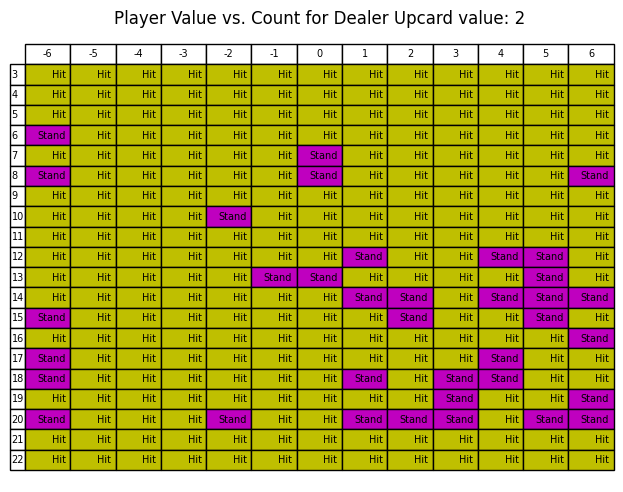

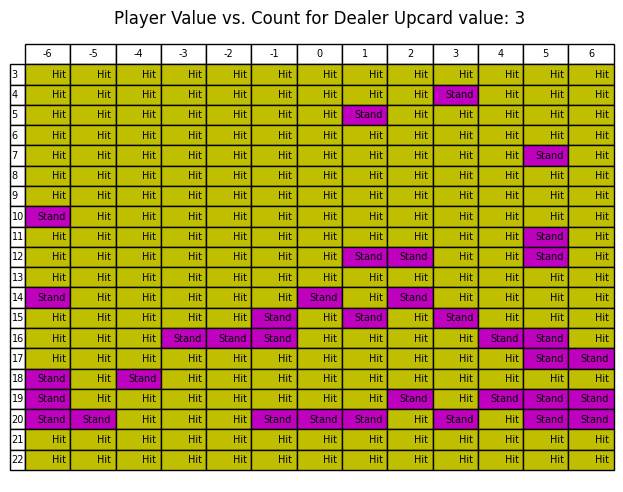

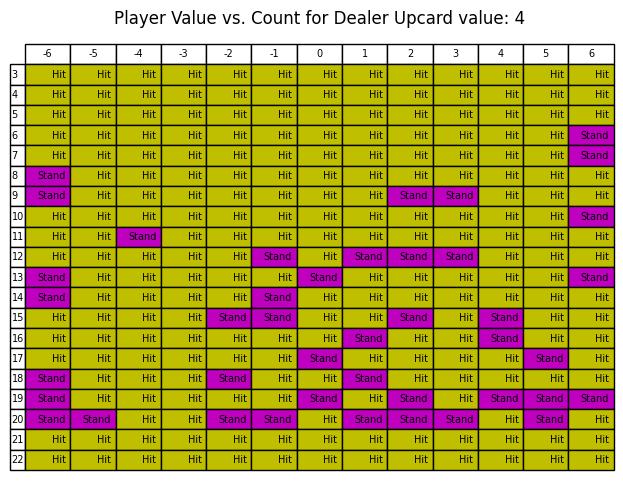

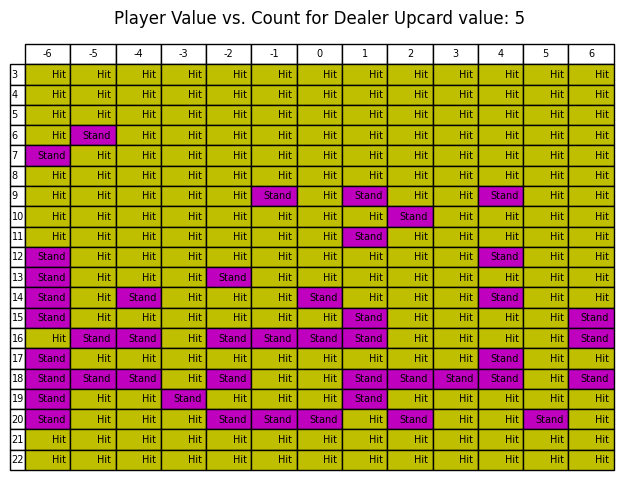

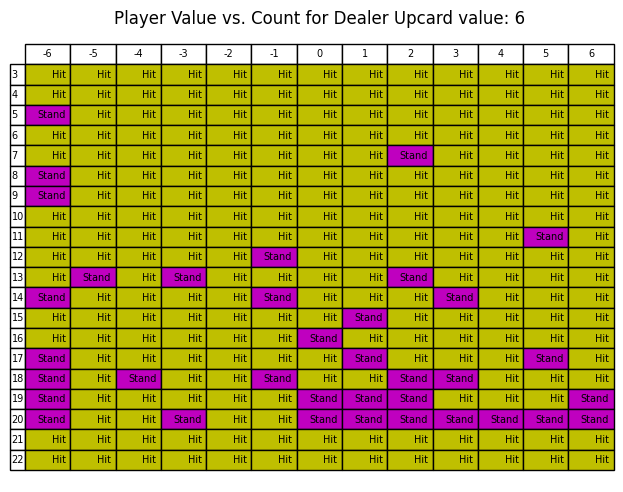

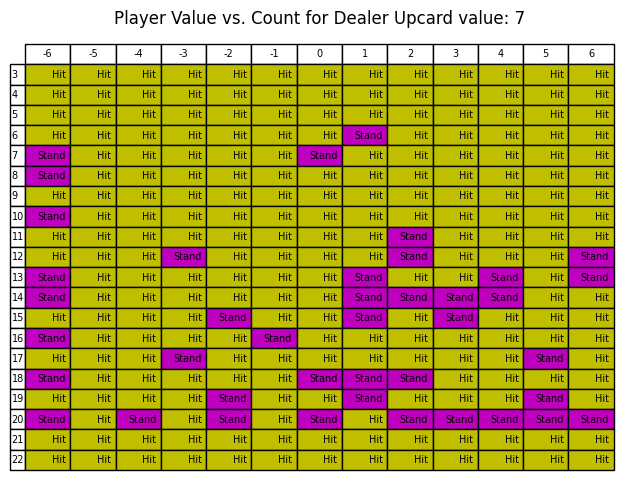

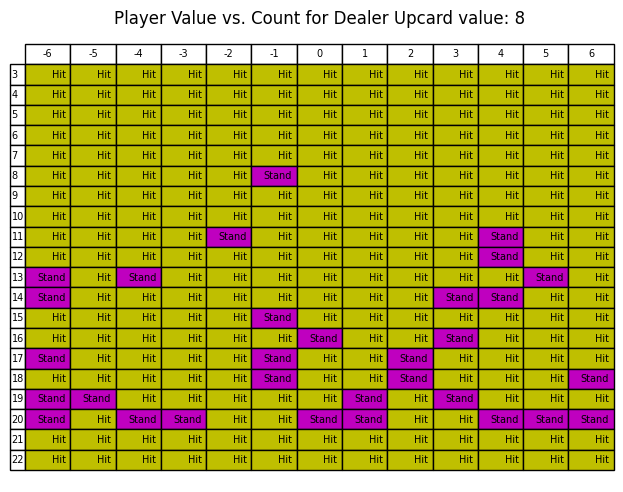

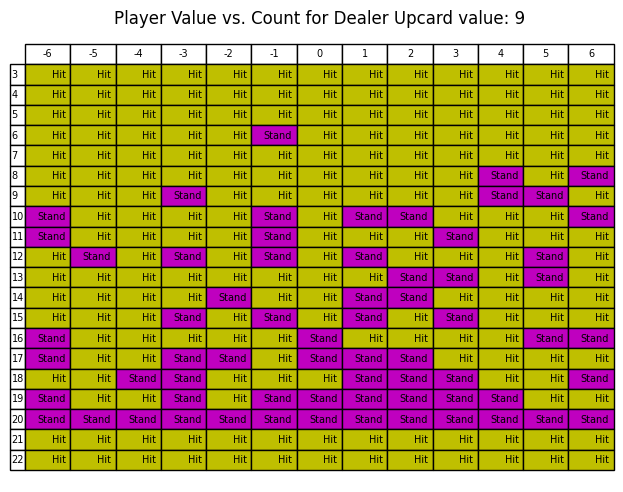

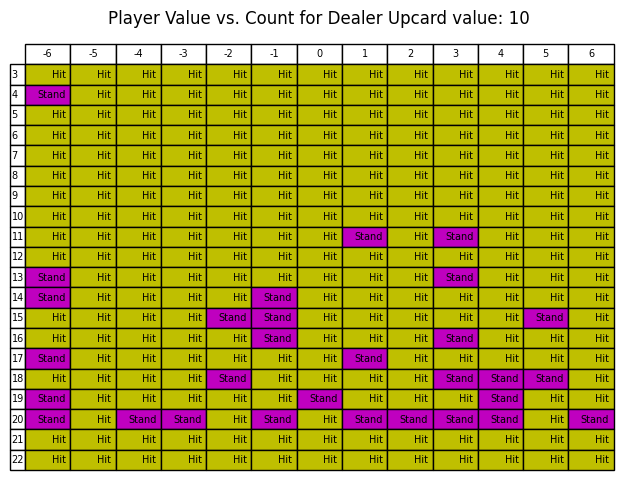

In [40]:
import matplotlib.pyplot as plt


import pandas as pd
new_Q_binary, new_Q_string, new_Q_colors = best_policy(new_Q)

df = pd.DataFrame(columns = range(-6, 7))

color_df = pd.DataFrame(columns = range(-6, 7))

print(df)

print(new_Q_string[2417:2430])

def get_indices_for_value1(value1, value2_fixed):
    size_range3 = 13  # Size of the third range (0-12)
    indices = []

    arr = []

    for value3 in range(size_range3):

        arr=[value1, value2_fixed, value3]
        index = get_Q_state_index(arr)
        indices.append(index)
        arrr = []

    return indices


print(get_indices_for_value1(6, 1))

# Example usage
value1 = 21  # Within the range 0-17
value2_fixed = 0  # A fixed value for range2 (0-9)

indices_list = get_indices_for_value1(value1, value2_fixed)
print(f"Indices for value1 = {value1} with value2 fixed at {value2_fixed}: {indices_list}")



for value in range(2, 11):
    for s in range(3, 23): # possible player values in the range 3 to 20

        indices_list = get_indices_for_value1(s-2, value)  # Adjusted for zero-based indexing
        start = indices_list[0]
        end = start + 13  # +1 because slice end index is exclusive

        df.loc[s] = new_Q_string[start:end]
        color_df.loc[s] = new_Q_colors[start:end]



    fig, ax = plt.subplots()


    ax.set_axis_off()


#ax.axis('tight')

    ax.table(cellText=df.values, cellColours=color_df.values, rowLabels=df.index, colLabels=df.columns, loc='center')

    fig.tight_layout()

    s1 = "Player Value vs. Count for Dealer Upcard value: "

    var = s1 + str(value)


    plt.title(var)
    plt.xlabel("Average Pulse")
    plt.ylabel("Calorie Burnage")

    plt.show()


    fig.savefig('/content/drive/MyDrive/CS_238/' + str(value) + '_Dealer_card_value.png', bbox_inches='tight', dpi = 1000)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


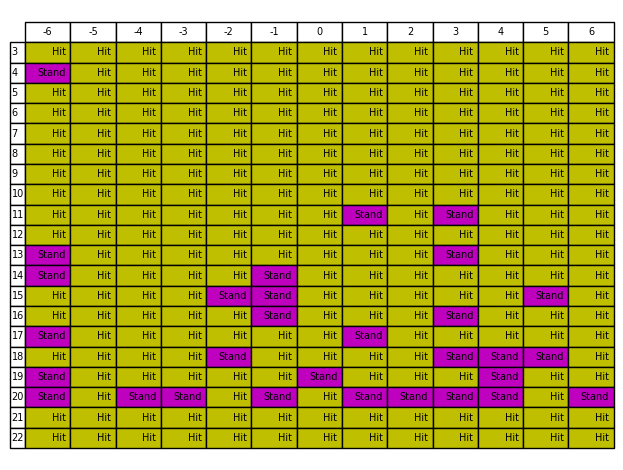

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# hide axes
#fig.patch.set_visible(False)
ax.set_axis_off()
#ax.axis('tight')

ax.table(cellText=df.values, cellColours=color_df.values, rowLabels=df.index, colLabels=df.columns, loc='center')

fig.tight_layout()


#plt.title("Blackjack actions for %d iterations and count" (num_times))
plt.xlabel("Average Pulse")
plt.ylabel("Calorie Burnage")

plt.show()

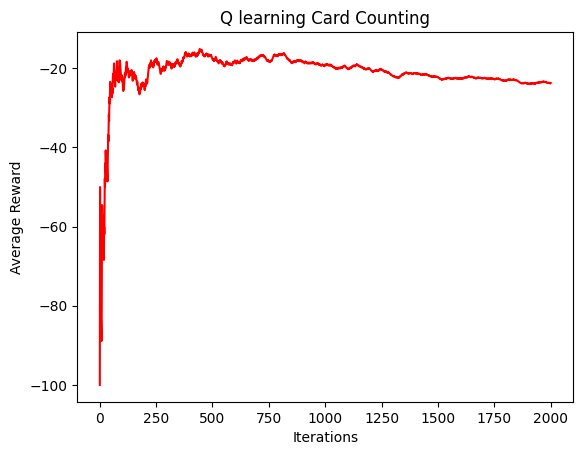

-23.7


In [42]:
import random
env = BlackjackEnv()

total_rewards = 0
NUM_EPISODES = 2000

reward_arr = [0] * NUM_EPISODES




for i in range(NUM_EPISODES):
    state = env.reset()

    while env.done == False:



        if (i % 10 == 0):
            env.bj_deck.shuffle()
            env.count = 0
            env.real_count = 0
            env.bj_deck.cards += env.cards_to_add


        if state[0] == 19: # Player was dealt Blackjack
            next_state, reward, env.done, info = env.step(1) # doesn't matter what action is taken.
            # don't do any th analysis for this episode. This is a useless episode.
            total_rewards += reward


        else:
            Q_index = get_Q_state_index(state)
            action = new_Q_binary[Q_index]

            new_state, reward, done, desc = env.step(action)
            state = new_state
            total_rewards += reward

        reward_arr[i] = (total_rewards)/(i+1)


x_axis = np.arange(1, 2001)

# data to be plotted


fig, ax = plt.subplots()

# Plotting
ax.set_title("Q learning Card Counting")
ax.set_xlabel("Iterations")
ax.set_ylabel("Average Reward")
ax.plot(x_axis, reward_arr, color="red")

# Display the plot
plt.show()

# Save the figure
#fig.savefig('/content/drive/MyDrive/CS_238/Blackjack_Card_Counting_Convergence_1000_sim.png', bbox_inches='tight', dpi=1000)

avg_reward = total_rewards / NUM_EPISODES
print(avg_reward)




#make a graph for the rewards over time for number of simulations

#make a graph for each of the different types of simulations

#make plots for different amount of runtimes (show the runtime given 100000000 simulations for non-cheating) then do the same thing for cheating but do lower number of simulations

#make plots for the scenarios for different counts

#Do the Q-learning algorithm

#

In [43]:
import random
env = BlackjackEnv()

total_rewards = 0
NUM_EPISODES = 2000

for i in range(NUM_EPISODES):
    env.reset()

    while env.done == False:
        action = env.action_space.sample()

        new_state, reward, done, desc = env.step(action)
        total_rewards += reward



    if (i % 10 == 0):
        env.bj_deck.shuffle()
        env.count = 0
        env.real_count = 0
        env.bj_deck.cards += env.cards_to_add

avg_reward = total_rewards / NUM_EPISODES
print(avg_reward)


-31.45
